In [106]:
from os.path import join
import json
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.misc import imread, imresize
import numpy as np

from time import time
import dlib
from sklearn.metrics.pairwise import euclidean_distances

In [117]:
.5*110000/3600

15.277777777777779

In [136]:
def getIoU(candidates):
    # Computes an IoU matrix from a list of rectangles
    IoU = np.zeros((len(candidates), len(candidates)))
    for i in xrange(len(candidates)):
        r1 = candidates[i]
        r1_area = float(r1.area())
        for j in xrange(i+1,len(candidates)):
            r2 = candidates[j]
            inter =  r1.intersect(r2).area()
            iou = inter / (r1_area+r2.area()-inter)
            IoU[i,j] = iou
            IoU[j,i] = iou
    return IoU

def getDistances(candidates):
    # Computes a distance matrix from a list of candidates
    centers = [((c.left()+c.right())/2,(c.top()+c.bottom())/2) for c in candidates]
    print(centers)
    return euclidean_distances(centers)

def getBoundingBoxes(im,n_boxes=10,verbose=False):
    # Takes an image an outputs a list of candidate bounding boxes
    im_size = np.prod(im.shape[:2])
    bbs = []
    dlib.find_candidate_object_locations(im,
                                         bbs,
                                         min_size=im_size//250,
                                         max_merging_iterations=10)
    candidates = []
    for r in bbs:
        x, y, w, h = r.left(),r.top(),r.width(),r.height()
        if max(float(w)/h, float(h)/w) >3.:
            continue
        candidates.append(r)
    if len(candidates)<1:
        return bbs
    if verbose:
        print("Image size = %d" % im_size)
        print("%d bounding boxes" % len(bbs))
        print("%d candidates after distorted removal" % len(candidates))
    IoU = getIoU(candidates)
    maxes = np.max(IoU,axis=0)
    args = np.argsort(maxes)[:n_boxes]
    out = [candidates[i] for i in args]
    return out

_ = getBoundingBoxes(im,n_boxes=100)

## First of all, parse data to get the image,Q,A triplets

In [ ]:
for split in 'train val'.split():
    images_path = "/srv/data/datasets/mscoco/images/" + split+"2014"
    image_ids_path = "/hhome/hbenyounes/vqa/datasets/vqa/"+split+"/img_ids.txt"
    image_ids = set([int(x.strip()) for x in open(image_ids_path).readlines()])
    image_paths = {}
    for x in image_ids:
        name = 'COCO_'+split+'2014_'+format(x, '012')+'.jpg'
        path = join(images_path,name)
        image_paths[x] = path
    N = len(image_ids)
    bb_file = open('datasets/vqa/'+split+'/bounding_boxes.json','w')
    tic = time()
    elapsed = 0.
    for k,i in enumerate(image_paths):
        if not k%50:
            eta = elapsed*(float(N)/(k+1) - 1)
            print("%s - %d/%d - elapsed = %1.2fs - eta = %1.2fs" % (split,k,N,elapsed,eta))
        p = image_paths[i]
        im = imread(p)
        bb = getBoundingBoxes(im,n_boxes=100)
        D = {i:[(b.left(), b.top(), b.width(), b.height()) for b in bb]}
        bb_file.write(json.dumps(D) + '\n')
        elapsed = time() - tic
    bb_file.close()

train - 0/82783 - elapsed = 0.00s - eta = 0.00s
train - 50/82783 - elapsed = 29.91s - eta = 48511.96s
train - 100/82783 - elapsed = 64.48s - eta = 52783.15s
train - 150/82783 - elapsed = 99.15s - eta = 54260.37s


In [3]:
images_path = "/srv/data/datasets/mscoco/images/train2014"
image_ids_path = "/hhome/hbenyounes/vqa/datasets/vqa/train/img_ids.txt"
image_ids = set([int(x.strip()) for x in open(image_ids_path).readlines()])
image_paths = {}
for x in image_ids:
    name = 'COCO_train2014_'+format(x, '012')+'.jpg'
    path = join(images_path,name)
    image_paths[x] = path
N = len(image_ids)

In [102]:


n_boxes = 100
for idx in image_paths:
    p = image_paths[idx]
    im = imread(p)
    candidates = getBoundingBoxes(im,n_boxes=n_boxes,verbose=True)
    plt.figure
    break

Image size = 273280
790 bounding boxes
747 candidates after distorted removal


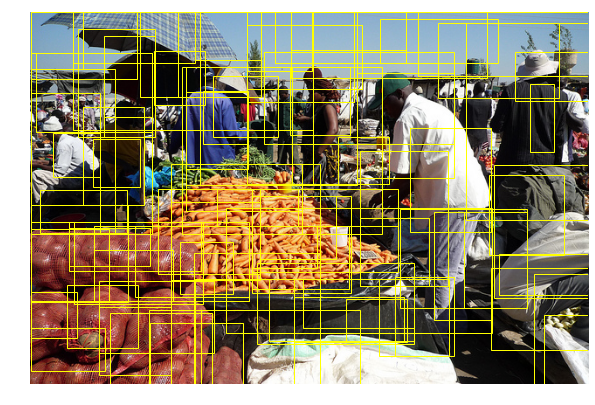

In [103]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(im)
plt.axis('off')
for i,c in enumerate(candidates):
    x,y,w,h = c.left(), c.top(), c.width(), c.height()
    patch = patches.Rectangle((x,y),w,h,
                              color='yellow',
                              linewidth=1,fill=False)
    ax.add_patch(patch)
plt.show()

In [ ]:
IOU = getIoU(candidates)
non_zero = np.greater(IOU,0)